# Homework 7: Problems

### ASTR-324, Spring 2018, Ivezic & Juric, University of Washington
https://github.com/uw-astr-324-s18/astr-324-s18/Astr324-S18-HW6.ipynb


## Problem 1: use KDE to make Hess-like diagrams

Use Kernel Density Estimation (KDE) with a top-hat, Gaussian, and exponential 
kernel to analyze 4-D data for variable stars from the SDSS and LINEAR surveys:
-- SDSS u-g and g-i colors,
-- LINEAR variability period (logP) and variability amplitude (A), that
you already encountered in Homework 6. Please produce the g-i vs. u-g, and 
A vs. logP, diagrams for each of the three kernels above (that is, make the 
analogs of Figure 6.3 from the textbook). Experiment with different kernel 
bandwidths, plotting one that visually seems "best" (i.e., a good balance of 
bias vs. variance) for each kernel.

Please change the original figure size (i.e. the size of Figure 6.3) so that 
individual panels in your solution have aspect ratios closer to what is common 
for color-magnitude diagrams (i.e., x:y $\approx$ 4:6 or so).


## Problem 2:  Unsupervised classification using GMM

Apply Gausian Mixture Model (GMM) to the 4-D data from the first Problem: 
the g-i and u-g colors, and Amplitude and logP determined from light curves.
You can use the astroML code from textbook figure 6.6 to search for clusters
(hint: adapt the GMM code we used in notebook for Week 9 for asteroids).

Assume that there are no more than 30 physical clusters.
a) plot BIC (and AIC if you want) as a function of the assumed number of 
clusters; what is the optimal number of clusters?
b) plot logP vs. g-i diagram and overplot ellipses (1.5 sigma level as in fig. 6.6) 
outlining each class for the best number of clusters.
c) what fraction of sample belongs to the most populous cluster (hint: look at gmm_best.weights_ variable)



## Problem 3: Your feedback! 

Please answer each question with a few words - you will help us a lot! 

Don't worry about being (too) critical - your critiques are actually the most 
useful feedback to us! 

You can add your text directly below, after each question. 

1) did you find power point slides, or jupyter notebook approach, easier to follow?

2) should we have spent more in-class time on analyzing notebook code line by line? 

3) should we have spent more or less in-class time on discussing theoretical background?

4) were there any topics that could be dropped, or minimized in coverage? 

5) can you think of any additional topics that should have been covered, or discussed
   in more detail? 
   
6) should we have covered more non-astronomical applications (e.g. text processing,
data harvesting from the web)? 
   
7) did you find homeworks useful learning experience?

8) were homeworks too easy, too hard, or just perfect? 

9) do you have any other advice on how to make this class more effective/relevant/interesting? 

<br>
# Homework 7: Solutions

### Some useful definitions and functions

In [15]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from scipy.stats import norm
from scipy.spatial import cKDTree
from scipy.stats import gaussian_kde
from sklearn.mixture import GaussianMixture as GMM
from sklearn.neighbors import KernelDensity
from astroML.datasets import fetch_LINEAR_geneva
from astroML.datasets import fetch_great_wall
from astroML.decorators import pickle_results
from astroML.plotting.tools import draw_ellipse
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

## Problem 1
First obtain LINEAR data for 6,146 stars using astroML built-in function: 

In [8]:
data = fetch_LINEAR_geneva()
# N.B. this is a 7-dimensional dataset
ug = data['ug']
gi = data['gi']
logP = data['logP']
A = data['amp']
# will need for GMM clustering analysis
X = np.vstack([data['gi'], data['logP'], data['ug'], data['amp']]).T

and plot a few diagrams just to make sure that data are fine...

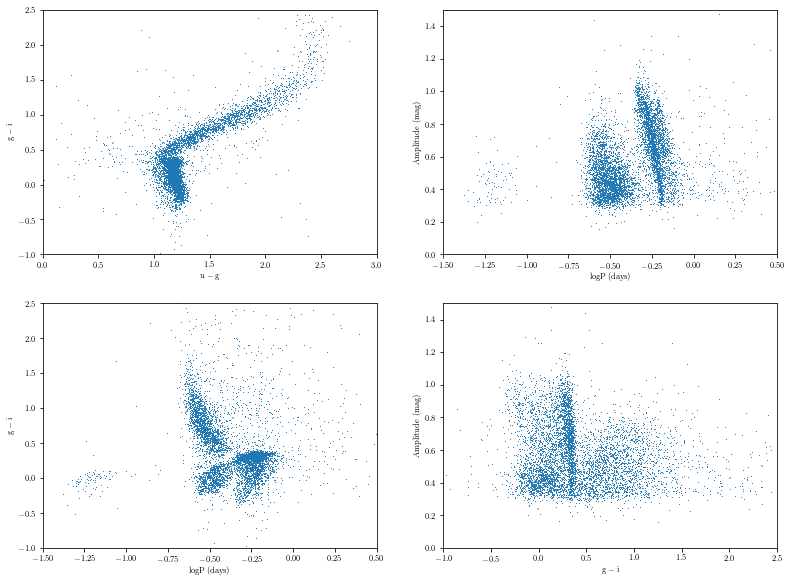

In [9]:
# set up the plot
fig = plt.figure(figsize=(12, 9), facecolor='w')
fig.subplots_adjust(left=0.1, right=0.95, wspace=0.2, bottom=0.1, top=0.93)

# plot the color-color plot
ax1 = fig.add_subplot(221)
ax1.scatter(ug, gi, s=0.9, lw=0)
ax1.set_xlim(0.0, 3.0)
ax1.set_ylim(-1.0, 2.5)
ax1.set_xlabel(r'${\rm u-g}$', color='k')
ax1.set_ylabel(r'${\rm g-i}$', color='k')

# plot the A vs. logP plot
ax2 = fig.add_subplot(222)
ax2.scatter(logP, A, s=0.9, lw=0)
ax2.set_xlim(-1.5, 0.5)
ax2.set_ylim(0.0, 1.5)
ax2.set_xlabel(r'${\rm logP \, (days)}$', color='k')
ax2.set_ylabel(r'${\rm Amplitude \,\, (mag)}$', color='k')

# g-i vs. logP
ax3 = fig.add_subplot(223)
ax3.scatter(logP, gi, s=0.9, lw=0)
ax3.set_xlim(-1.5, 0.5)
ax3.set_ylim(-1.0, 2.5)
ax3.set_xlabel(r'${\rm logP \, (days)}$', color='k')
ax3.set_ylabel(r'${\rm g-i}$', color='k')

# A vs. g-i 
ax4 = fig.add_subplot(224)
ax4.scatter(gi, A, s=0.9, lw=0)
ax4.set_xlim(-1.0, 2.5)
ax4.set_ylim(0.0, 1.5)
ax4.set_xlabel(r'${\rm g-i}$', color='k')
ax4.set_ylabel(r'${\rm Amplitude \,\, (mag)}$', color='k')

plt.show()

And then do the required KDE analysis...

In [21]:
def makeKDE1(ugC, giC, h):
    #------------------------------------------------------------
    # Create  the grid on which to evaluate the results
    xmin, xmax = (0.0, 3.0)
    ymin, ymax = (-1, 2.5)
    # step in each color coordinate: 0.02 mag
    Nx = 150
    Ny = 175
    # data structure needed for KDE code 
    XC = np.vstack([ugC, giC]).T
    
    #------------------------------------------------------------
    # Evaluate for several models
    Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                                np.linspace(ymin, ymax, Ny)))).T

    kernels = ['gaussian', 'tophat', 'exponential']
    dens = []

    kde1 = KernelDensity(h, kernel='gaussian')
    log_dens1 = kde1.fit(XC).score_samples(Xgrid)
    dens1 = XC.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))

    kde2 = KernelDensity(h, kernel='tophat')
    log_dens2 = kde2.fit(XC).score_samples(Xgrid)
    dens2 = XC.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))

    kde3 = KernelDensity(h, kernel='exponential')
    log_dens3 = kde3.fit(XC).score_samples(Xgrid)
    dens3 = XC.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))

    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(10, 15))
    fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                        hspace=0.1, wspace=0.1)

    # First plot: scatter the points
    ax1 = plt.subplot(221)
    ax1.scatter(XC[:, 0], XC[:, 1], s=1, lw=0, c='k')
    ax1.text(0.95, 0.9, "input", ha='right', va='top',
             transform=ax1.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    # Second plot: gaussian kernel
    ax2 = plt.subplot(222)
    ax2.imshow(dens1, origin='lower', aspect='auto', norm=Normalize(),
               extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.binary)
    ax2.text(0.95, 0.9, "Gaussian $(h=%.2f)$" % h, ha='right', va='top',
             transform=ax2.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    # Third plot: top-hat kernel
    ax3 = plt.subplot(223)
    ax3.imshow(dens2, origin='lower', aspect='auto', norm=Normalize(),
               extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.binary)
    ax3.text(0.95, 0.9, "top-hat $(h=%.2f)$" % h, ha='right', va='top',
             transform=ax3.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    # Fourth plot: exponential kernel
    ax4 = plt.subplot(224)
    ax4.imshow(dens3, origin='lower', aspect='auto', norm=Normalize(),
               extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.binary)
    ax4.text(0.95, 0.9, "exponential $(h=%.2f)$" % h, ha='right', va='top',
             transform=ax4.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    for ax in [ax3, ax4]:
        ax.set_xlabel('$u-g$')

    for ax in [ax2, ax4]:
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    for ax in [ax1, ax3]:
        ax.set_ylabel('$g-i$')

    plt.show()

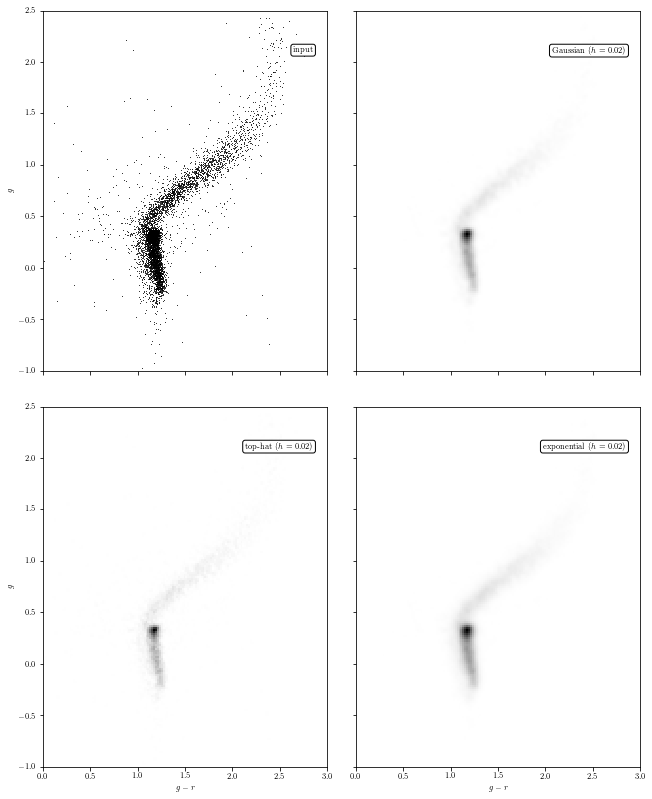

In [24]:
makeKDE1(ug, gi, 0.02)

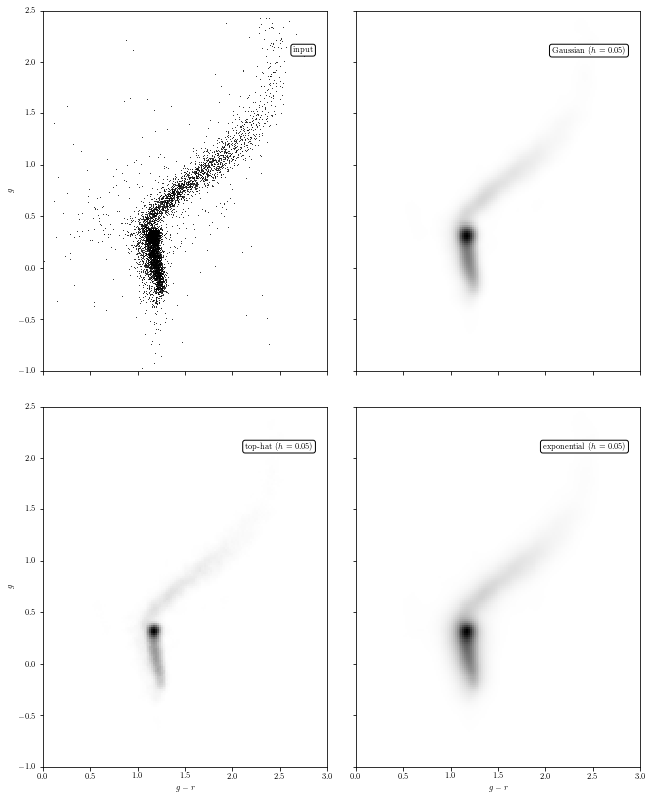

In [23]:
makeKDE1(ug, gi, 0.05)

In [25]:
def makeKDE2(logP, A, h):
    #------------------------------------------------------------
    # Create  the grid on which to evaluate the results
    xmin, xmax = (-1.5, 0.5)
    ymin, ymax = (0.0, 1.5)
    # step in each color coordinate: 0.02 mag
    Nx = 200
    Ny = 150
    # data structure needed for KDE code 
    XC = np.vstack([logP, A]).T
    
    #------------------------------------------------------------
    # Evaluate for several models
    Xgrid = np.vstack(map(np.ravel, np.meshgrid(np.linspace(xmin, xmax, Nx),
                                                np.linspace(ymin, ymax, Ny)))).T

    kernels = ['gaussian', 'tophat', 'exponential']
    dens = []

    kde1 = KernelDensity(h, kernel='gaussian')
    log_dens1 = kde1.fit(XC).score_samples(Xgrid)
    dens1 = XC.shape[0] * np.exp(log_dens1).reshape((Ny, Nx))

    kde2 = KernelDensity(h, kernel='tophat')
    log_dens2 = kde2.fit(XC).score_samples(Xgrid)
    dens2 = XC.shape[0] * np.exp(log_dens2).reshape((Ny, Nx))

    kde3 = KernelDensity(h, kernel='exponential')
    log_dens3 = kde3.fit(XC).score_samples(Xgrid)
    dens3 = XC.shape[0] * np.exp(log_dens3).reshape((Ny, Nx))

    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(10, 15))
    fig.subplots_adjust(left=0.12, right=0.95, bottom=0.2, top=0.9,
                        hspace=0.1, wspace=0.1)

    # First plot: scatter the points
    ax1 = plt.subplot(221)
    ax1.scatter(XC[:, 0], XC[:, 1], s=1, lw=0, c='k')
    ax1.text(0.95, 0.9, "input", ha='right', va='top',
             transform=ax1.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    # Second plot: gaussian kernel
    ax2 = plt.subplot(222)
    ax2.imshow(dens1, origin='lower', aspect='auto', norm=Normalize(),
               extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.binary)
    ax2.text(0.95, 0.9, "Gaussian $(h=%.2f)$" % h, ha='right', va='top',
             transform=ax2.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    # Third plot: top-hat kernel
    ax3 = plt.subplot(223)
    ax3.imshow(dens2, origin='lower', aspect='auto', norm=Normalize(),
               extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.binary)
    ax3.text(0.95, 0.9, "top-hat $(h=%.2f)$" % h, ha='right', va='top',
             transform=ax3.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    # Fourth plot: exponential kernel
    ax4 = plt.subplot(224)
    ax4.imshow(dens3, origin='lower', aspect='auto', norm=Normalize(),
               extent=(xmin, xmax, ymin, ymax), cmap=plt.cm.binary)
    ax4.text(0.95, 0.9, "exponential $(h=%.2f)$" % h, ha='right', va='top',
             transform=ax4.transAxes,
             bbox=dict(boxstyle='round', ec='k', fc='w'))

    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)

    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    for ax in [ax3, ax4]:
        ax.set_xlabel(r'${\rm logP \, (days)}$')

    for ax in [ax2, ax4]:
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    for ax in [ax1, ax3]:
        ax.set_ylabel(r'${\rm Amplitude \,\, (mag)}$')
             
    plt.show()

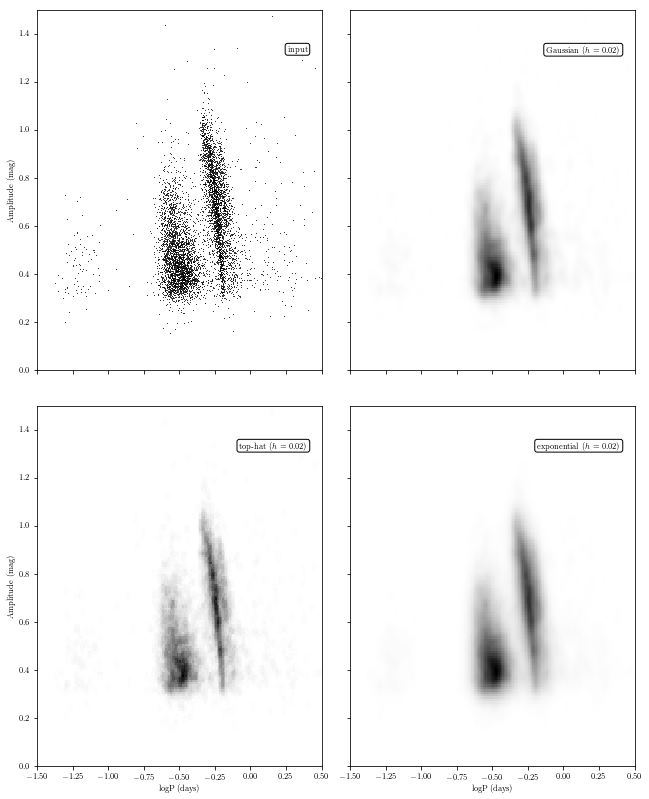

In [26]:
makeKDE2(logP, A, 0.02)

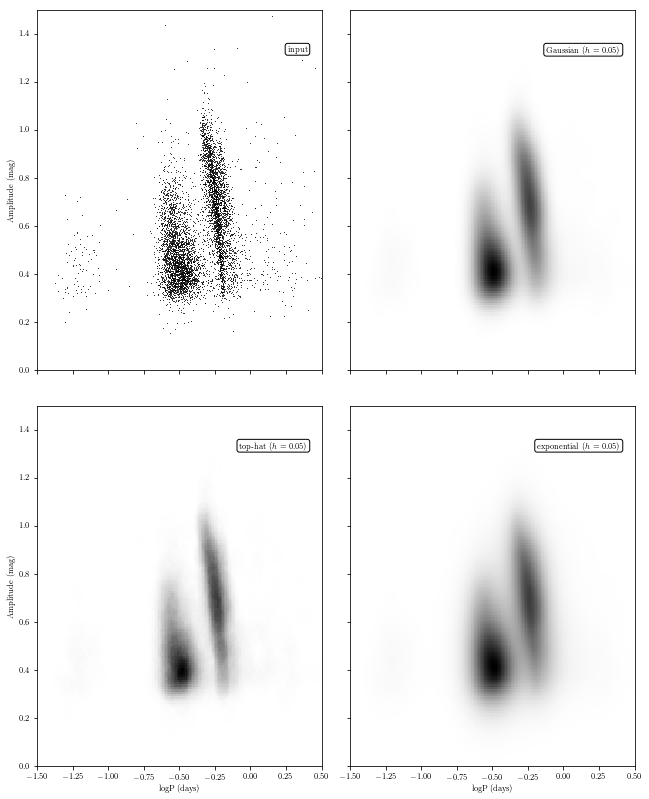

In [27]:
makeKDE2(logP, A, 0.05)

## Problem 2: Gausian Mixture Model


In [12]:
# Compute GMM models & AIC/BIC
N = np.arange(1, 30)
def compute_GMM(N, covariance_type='full', max_iter=100):
    models = [None for n in N]
    for i in range(len(N)):
        models[i] = GMM(n_components=N[i], max_iter=max_iter,
                        covariance_type=covariance_type)
        models[i].fit(X)
    return models

models = compute_GMM(N)
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]
i_best = np.argmin(BIC)
gmm_best = models[i_best]

In [13]:
print "best fit converged:", gmm_best.converged_
print "BIC: n_components =  %i" % N[i_best]

best fit converged: True
BIC: n_components =  14


0 5 0.20862516635518025
1 3 0.1820617571330773
2 10 0.13148027887999944
3 4 0.12993251454285046
4 6 0.06513900728214966
5 2 0.06474582444421398
6 0 0.0630888274930602
7 8 0.03577249564056678
8 9 0.03426129049432233
9 12 0.03260737025231283
10 11 0.023330037475065252
11 7 0.01666835371487187
12 13 0.011798953936325036
13 1 0.00048812235600390535


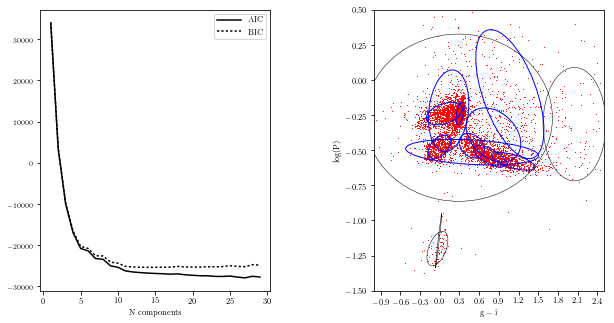

In [14]:
#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(9, 6))
fig.subplots_adjust(wspace=0.45, bottom=0.25, top=0.9, left=0.1, right=0.97)

# plot AIC/BIC
ax = fig.add_subplot(121)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, ':k', label='BIC')
ax.legend(loc=1)
ax.set_xlabel('N components')
plt.setp(ax.get_yticklabels(), fontsize=7)

# plot best configurations for AIC and BIC
ax = fig.add_subplot(122)
ax.scatter(gi, logP, c='red', s=0.9, lw=0)

ind = np.argsort(gmm_best.weights_)[::-1]
for cnt, i in enumerate(ind[:N[i_best]]):
    mu = gmm_best.means_[i]
    C = gmm_best.covariances_[i]
    w = gmm_best.weights_[i]
    print cnt, i, w
    if (cnt<10):
        draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', lw=1.0, ec='blue')
    else:
        draw_ellipse(mu, C, scales=[1.5], ax=ax, fc='none', lw=0.5, ec='k')
 

ax.set_ylim(-1.5, 0.5)
ax.set_xlim(-1.0, 2.5)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.3))
ax.set_xlabel(r'$\rm g-i$')
ax.set_ylabel(r'$\rm log(P)$')

plt.show()